# Using ART on Traffic Sign Classifier

In this notebook, I demonstrated the use of Adversarial Robustness Tooolbox (ART) on Traffic Sign Classifier.

ART is a library developed by "IBM Research" which is dedicated to adversarial machine learning. Its purpose is to allow rapid crafting and analysis of attacks and defense methods for machine learning models. ART provides an implementation for many state-of-the-art methods for attacking and defending classifiers. 

- ART Demo: https://art-demo.mybluemix.net
- ART Blog: https://www.ibm.com/blogs/research/2018/04/ai-adversarial-robustness-toolbox/
- ART Github: https://github.com/IBM/adversarial-robustness-toolbox

#### Here we load all the libraries needed to run this notebook.

In [1]:
# common import for all cells
SEED=202
DATA_DIR='/Users/zoyagerdabad/ART/dataset/German_TS/'
OUT_DIR ='/Users/zoyagerdabad/ART/model/'

# standard libs
import pickle
import csv
from timeit import default_timer as timer
import os
from os.path import join, abspath, expanduser
import sys

#visualisation
%matplotlib inline

import matplotlib.pyplot as plt 
from IPython.display import Image
from IPython.display import display

# numerical Libraries 
import cv2
import math

import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf
tf.set_random_seed(SEED)
from tensorflow import keras
from tensorflow.python.training import moving_averages
from tensorflow.contrib.framework import add_model_variable
sess = tf.InteractiveSession()

import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image

# ART Libraries
from art.classifiers import TFClassifier
from art.utils import load_dataset
from art.attacks.fast_gradient import FastGradientMethod
from art.attacks import ProjectedGradientDescent
from art.detection.detector import BinaryInputDetector

Using TensorFlow backend.


---
## Step 0: Load The Data

In this section we define a function to load our Traffic Sign dataset which in "Pickle" file format.

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
# Load pickled data  

def load_data(): 
    training_file  = DATA_DIR + '/train.p'
    testing_file   = DATA_DIR + '/test.p'
    classname_file = DATA_DIR + '/signnames.csv'

    classnames = []
    with open(classname_file) as _f:
        rows = csv.reader(_f, delimiter=',')
        next(rows, None)  # skip the headers
        for i, row in enumerate(rows):
            assert(i==int(row[0]))
            classnames.append(row[1])
 
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test   = test['features'], test['labels']
    
    
    X_train  = X_train.astype(np.float32)
    y_train  = y_train.astype(np.int32)
    X_test   = X_test.astype(np.float32)
    y_test   = y_test.astype(np.int32)
    
    return  classnames, X_train, y_train, X_test, y_test 


---

## Step 1: Dataset Summary & Exploration



In [3]:
classnames, X_train, y_train, X_test, y_test = load_data() 
 
# Number of training examples 
num_train = len(X_train)

# Number of testing examples.
num_test = len(X_test)

# the shape of an traffic sign image
_, height, width, channel = X_train.shape
image_shape = (height, width, channel)

# Number of unique classes/labels in the dataset
num_class = len(np.unique(y_train))


print("Number of training examples =", num_train )
print("Number of testing examples =", num_test )
print("Image data shape =", image_shape)
print("Number of classes =", num_class)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization

In this section, we will visualize the dataset to see different what different classes look like.
Also we demonstrate the sample count of each class.

This Section might take couple of seconds - minutes to complete (based on how powerful the system you are working on is)

** training data summary **
	1st column: label(image)
	2nd column: mean image
	other column: example images
	black text: label
	blue text: sample count for each class and histogram plot


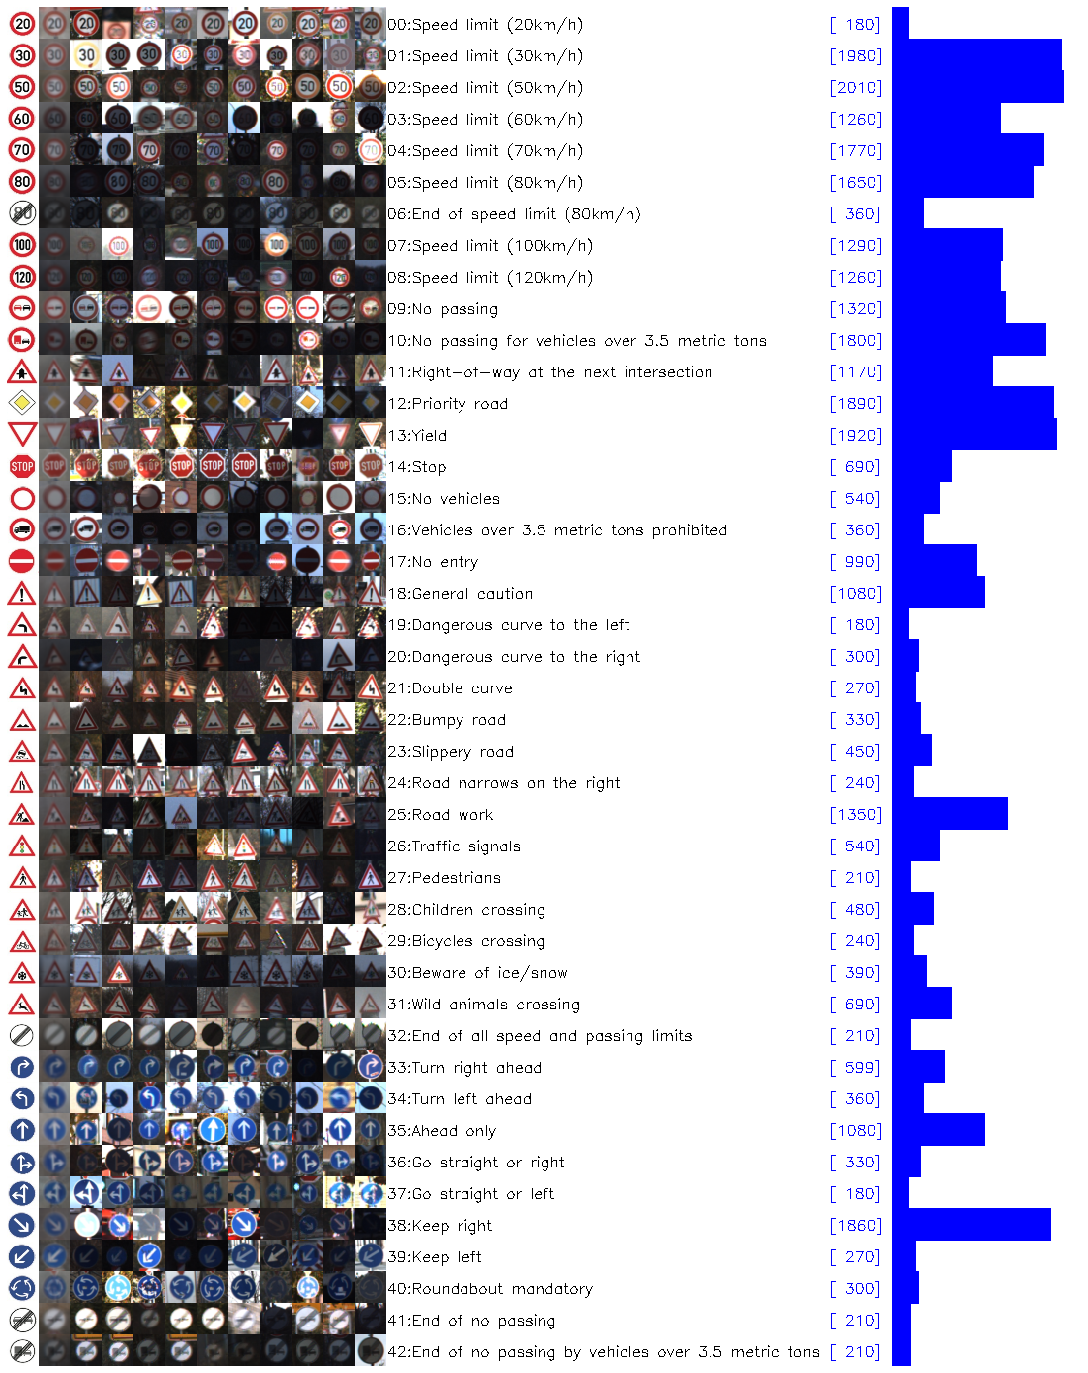

In [4]:
# Some functions to help us draw graphs

def get_label_image(c): 
    img=cv2.imread(DATA_DIR+'/signnames_all.jpg',1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W, _ = img.shape
    dH = H/7.
    dW = W/7.105
    y = c//7
    x = c%7 
    label_image = img[round(y*dH):round(y*dH+dH), round(x*dW):round(x*dW+dW),:]
    label_image = cv2.resize(label_image, (0,0), fx=32./dW, fy=32./dH,)
    return label_image


def insert_subimage(image, sub_image, y, x): 
    h, w, c = sub_image.shape
    image[y:y+h, x:x+w, :]=sub_image 
    return image


# Start Visualizing the dataset

train_images, train_labels = X_train, y_train

#results image
num_sample=10
results_image = 255.*np.ones(shape=(num_class*height,(num_sample+2+22)*width, channel),dtype=np.float32)
for c in range(num_class):
    label_image = get_label_image(c)
    insert_subimage(results_image, label_image, c*height, 0)

    #make mean
    idx = list(np.where(train_labels== c)[0])
    mean_image = np.average(train_images[idx], axis=0)
    insert_subimage(results_image, mean_image, c*height, width)

    #make random sample
    for n in range(num_sample):
        sample_image = train_images[np.random.choice(idx)]
        insert_subimage(results_image, sample_image, c*height, (2+n)*width)

    #print summary
    count=len(idx)
    percentage = float(count)/float(len(train_images))
    cv2.putText(results_image, '%02d:%-6s'%(c, classnames[c]), ((2+num_sample)*width, int((c+0.7)*height)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
    cv2.putText(results_image, '[%4d]'%(count), ((2+num_sample+14)*width, int((c+0.7)*height)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1)
    cv2.rectangle(results_image,((2+num_sample+16)*width, c*height),((2+num_sample+16)*width + round(percentage*3000), (c+1)*height),(0,0,255),-1)

 
    cv2.imwrite(DATA_DIR+'/data_summary.jpg',cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))

print('** training data summary **')
print('\t1st column: label(image)')
print('\t2nd column: mean image')
print('\tother column: example images')
print('\tblack text: label')
print('\tblue text: sample count for each class and histogram plot')
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()

----

## Step 2: Data Preprocessing & Model Architecture



### First we need to preprocess our dataset so it is ready to be fed to our model

One of the challanges with DNNs is that they require massive amount of trainig data, which may not always be accessible. Therefore, data scientists take advantage of a technique called "Data Augmentation". This method allows you to increase the size of your dataset using existing images. 

The following is being done on the data in next cells:


- We first flip the train sample to extend the training set to 62259.

- Next, to keep the class balance, we first re-sample the training set so that we have 20000 samples per class. This gives 43x2000=860000 train samples.

- Finally, we randomly select 80% train samples to add random geometric transform and illumination transform. Geometric transform include rotate, scale, transalate and perspective distortion noise. Illumination transform includes brightness, contast and saturation. These transforms are selected to mimick the data variations we found in the training images, which we have shown above.

In [5]:
### Generate additional data

# split into train and validation. 
def split_data(X_train, y_train, num_valid=3000): 
    # num_valid = num of validation samples
     
    num   = len(y_train)   # 39209 
    index = list(range(num))
    random.shuffle(index)
    train_index=index[num_valid:]
    valid_index=index[:num_valid]


    train_images = X_train[train_index] 
    train_labels = y_train[train_index]
    valid_images = X_train[valid_index] 
    valid_labels = y_train[valid_index] 
   
    return  train_images, train_labels,  valid_images, valid_labels

#  this expand the train data by flipping.
#  Note: this code is from : http://navoshta.com/traffic-signs-classification/ 

def extend_data_by_flipping(images, labels):

    X=images
    y=labels

    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38],
    ])
    num_classes = 43

    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype=np.float32)
    y_extended = np.empty([0], dtype=np.int32)

    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis=0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis=0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

    extend_datas  = X_extended
    extend_labels = y_extended
    return (extend_datas, extend_labels)

# use opencv to do data agumentation
# see also: https://github.com/dmlc/mxnet/blob/master/python/mxnet/image.py
def perturb(image, keep, angle_limit=15, scale_limit=0.1, translate_limit=3, distort_limit=3, illumin_limit=0.7):

    u=np.random.uniform()
    if u>keep :
        (W, H, C) = image.shape
        center = np.array([W / 2., H / 2.])
        da = np.random.uniform(low=-1, high=1) * angle_limit/180. * math.pi
        scale = np.random.uniform(low=-1, high=1) * scale_limit + 1

        cc = scale*math.cos(da)
        ss = scale*math.sin(da)
        rotation    = np.array([[cc, ss],[-ss,cc]])
        translation = np.random.uniform(low=-1, high=1, size=(1,2)) * translate_limit
        distort     = np.random.standard_normal(size=(4,2)) * distort_limit

        pts1 = np.array([[0., 0.], [0., H], [W, H], [W, 0.]])
        pts2 = np.matmul(pts1-center, rotation) + center  + translation

        #add perspective noise
        pts2 = pts2 + distort


        #http://milindapro.blogspot.jp/2015/05/opencv-filters-copymakeborder.html
        matrix  = cv2.getPerspectiveTransform(pts1.astype(np.float32), pts2.astype(np.float32)) 
        perturb = cv2.warpPerspective(image, matrix, (W, H), flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)  # BORDER_WRAP  #BORDER_REFLECT_101  #cv2.BORDER_CONSTANT  BORDER_REPLICATE

        #brightness, contrast, saturation-------------
        #from mxnet code
        if 1:  #brightness
            alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
            perturb *= alpha
            perturb = np.clip(perturb,0.,255.)
            pass

        if 1:  #contrast
            coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

            alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
            gray = perturb * coef
            gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
            perturb *= alpha
            perturb += gray
            perturb = np.clip(perturb,0.,255.)
            pass

        if 1:  #saturation
            coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

            alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
            gray = perturb * coef
            gray = np.sum(gray, axis=2, keepdims=True)
            gray *= (1.0 - alpha)
            perturb *= alpha
            perturb += gray
            perturb = np.clip(perturb,0.,255.)
            pass

        return perturb

    else:
        return image
    
    
def make_perturb_images(images, keep ):
    arguments = np.zeros(images.shape)
    for n in range(len(images)):
        arguments[n] = perturb(images[n],keep = keep)

    return arguments


# sample and shuffle the data such that each class has equal number of samples for training
def shuffle_data_uniform(datas, labels, num_class, num_per_class=None):

    if num_per_class is None:
        max_count = 0
        for c in range(num_class):
            idx = list(np.where(labels == c)[0])
            count = len(idx)
            max_count = max(count, max_count)
        num_per_class = max_count

    index = []
    for c in range(num_class):
        idx = list(np.where(labels == c)[0])
        index = index + list(np.random.choice(idx, num_per_class))

    random.shuffle(index)
    shuffle_datas  = datas[index]
    shuffle_labels = labels[index]

    return shuffle_datas, shuffle_labels


#generate next batch for sdg
def generate_train_batch_next(datas, labels, n, batch_size):
    i = n*batch_size
    batch_datas  = datas [i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    return batch_datas, batch_labels


The following cell applies all the different transformation we defined previously, to the dataset.

**This section may take couple of seconds - minutes to complete (based on the strenght of your system)**

** some data setting **
	height, width, channel = 32, 32, 3
	num_test  = 12630
	num_valid = 3000
	num_train = 31799

	num_train (after flip)= 54644
	num_argument = 860000


examples of argument images (first column is orginal)


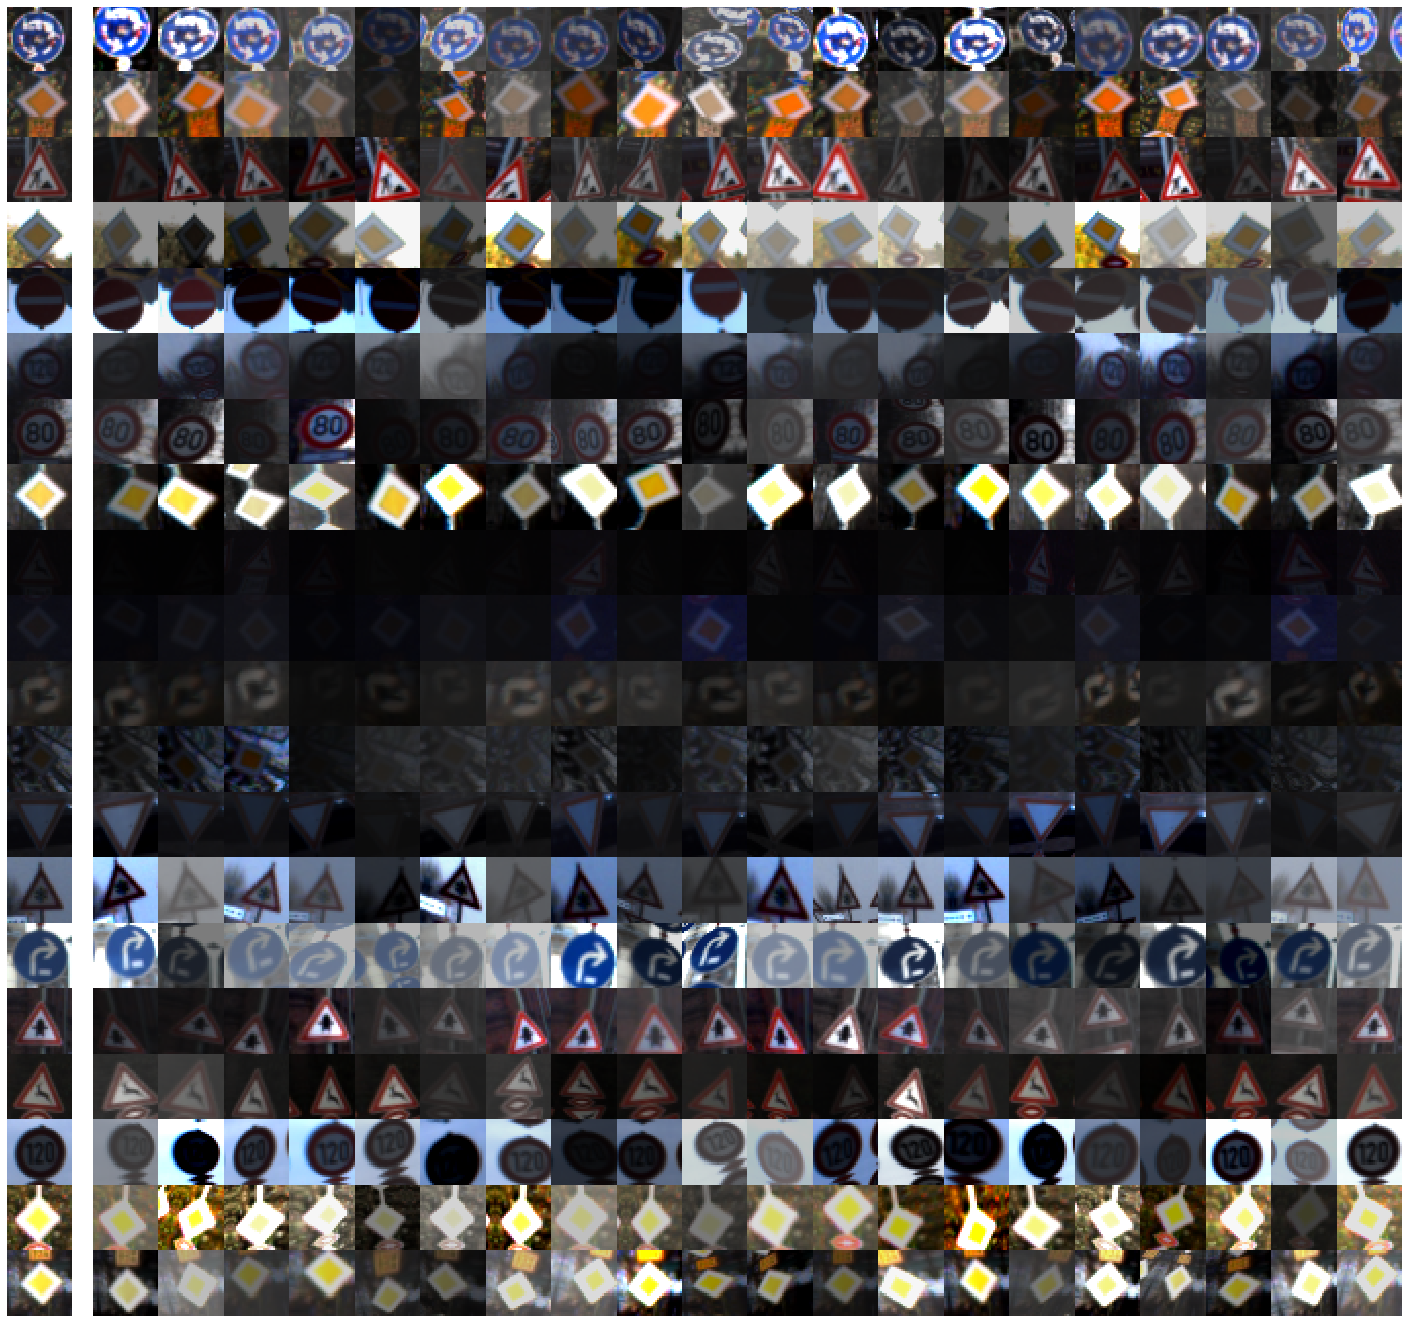

In [6]:
#prepare all data here 
classnames, X_train, y_train, X_test, y_test = load_data() 

train_images, train_labels,  valid_images, valid_labels = split_data(X_train, y_train)
test_images, test_labels = X_test, y_test
 
num_train = len(train_images)
num_valid = len(valid_images)
num_test  = len(test_images)
    
print('** some data setting **')
print('\theight, width, channel = %d, %d, %d'%(height, width, channel))
print('\tnum_test  = %d'%num_test)
print('\tnum_valid = %d'%num_valid)
print('\tnum_train = %d'%num_train)

#train data filpping.
train_images, train_labels = extend_data_by_flipping(train_images, train_labels) 
num_train_flip = len(train_images)
print('')
print('\tnum_train (after flip)= %d' % num_train_flip )
 
#train data augmentation 
keep = 0.20   # 0.50   0.25 0.20   #0.15
num_per_class = 20000
num_argument = num_per_class*num_class
print('\tnum_argument = %d' % num_argument)     
    
    
#example of new generated train data -------------------------------------------- 
print('\n')
print('examples of argument images (first column is orginal)')
 

# results image
num_sample = 20
perturbance_per_sample = 20

results_image = 255. * np.ones(shape=(num_sample * height, (perturbance_per_sample+1)* width+10, channel),dtype=np.float32)

for j in range(num_sample):
    i = random.randint(0, num_train_flip - 1)

    image = train_images[i]
    insert_subimage(results_image, image, j * height, 0)

    for k in range(0, perturbance_per_sample):
        perturb_image = perturb(image, keep=0)
        insert_subimage(results_image, perturb_image, j*height, (k+1)*width+10)

         
cv2.imwrite(DATA_DIR+'/data_argument.jpg',cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()
    

### In this section we define our DNN layers and architecture



In [7]:
##  global varaiables ##
IS_TRAIN_PHASE = tf.placeholder(dtype=tf.bool, name='is_train_phase')

def conv2d(input, num_kernels=1, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, name='conv'):

    input_shape = input.get_shape().as_list()
    assert len(input_shape)==4
    C = input_shape[3]
    H = kernel_size[0]
    W = kernel_size[1]
    K = num_kernels

    ##[filter_height, filter_width, in_channels, out_channels]
    w    = tf.get_variable(name=name+'_weight', shape=[H, W, C, K], initializer=tf.truncated_normal_initializer(stddev=0.1))
    conv = tf.nn.conv2d(input, w, strides=stride, padding=padding, name=name)
    if has_bias:
        b = tf.get_variable(name=name + '_bias', shape=[K], initializer=tf.constant_initializer(0.0))
        conv = conv+b

    return conv


def relu(input, name='relu'):
    act = tf.nn.relu(input, name=name)
    return act

def prelu(input, name='prelu'):
    alpha = tf.get_variable(name=name+'_alpha', shape=input.get_shape()[-1],
                       #initializer=tf.constant_initializer(0.25),
                        initializer=tf.random_uniform_initializer(minval=0.1, maxval=0.3),
                        dtype=tf.float32)
    pos = tf.nn.relu(input)
    neg = alpha * (input - abs(input)) * 0.5

    return pos + neg


# very leaky relu
def vlrelu(input, alpha=0.25, name='vlrelu'): #  alpha between 0.1 to 0.5
    act =tf.maximum(alpha*input,input)
    return act

def maxpool(input, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, name='max' ):
    H = kernel_size[0]
    W = kernel_size[1]
    pool = tf.nn.max_pool(input, ksize=[1, H, W, 1], strides=stride, padding=padding, name=name)
    return pool

def avgpool(input, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, is_global_pool=False, name='avg'):

    if is_global_pool==True:
        input_shape = input.get_shape().as_list()
        assert len(input_shape) == 4
        H = input_shape[1]
        W = input_shape[2]

        pool = tf.nn.avg_pool(input, ksize=[1, H, W, 1], strides=[1,H,W,1], padding='VALID', name=name)
        pool = flatten(pool)

    else:
        H = kernel_size[0]
        W = kernel_size[1]
        pool = tf.nn.avg_pool(input, ksize=[1, H, W, 1], strides=stride, padding=padding, name=name)

    return pool


def dropout(input, keep=1.0, name='drop'):
    #drop = tf.cond(IS_TRAIN_PHASE, lambda: tf.nn.dropout(input, keep), lambda: input)
    drop = tf.cond(IS_TRAIN_PHASE,
                   lambda: tf.nn.dropout(input, keep),
                   lambda: tf.nn.dropout(input, 1))
    return drop


def flatten(input, name='flat'):
    input_shape = input.get_shape().as_list()        # list: [None, 9, 2]
    dim   = np.prod(input_shape[1:])                 # dim = prod(9,2) = 18
    flat  = tf.reshape(input, [-1, dim], name=name)  # -1 means "all"
    return flat

def concat(input, name='cat'):
    cat = tf.concat(axis=3, values=input, name=name)
    return cat


#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard4/tf.contrib.layers.batch_norm.md
#http://www.bubufx.com/detail-1792794.html
def bn (input, decay=0.9, eps=1e-5, name='bn'):
    with tf.variable_scope(name) as scope:
        bn = tf.cond(IS_TRAIN_PHASE,
            lambda: tf.contrib.layers.batch_norm(input,  decay=decay, epsilon=eps, center=True, scale=True,
                              is_training=1,reuse=None,
                              updates_collections=None, scope=scope),
            lambda: tf.contrib.layers.batch_norm(input, decay=decay, epsilon=eps, center=True, scale=True,
                              is_training=0, reuse=True,
                              updates_collections=None, scope=scope))

    return bn


# basic building blocks

def conv2d_bn_relu(input, num_kernels=1, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', name='conv'):
    with tf.variable_scope(name) as scope:
        block = conv2d(input, num_kernels=num_kernels, kernel_size=kernel_size, stride=stride, padding=padding, has_bias=False)
        block = bn(block)
        block = relu(block)
    return block


def bn_relu_conv2d (input, num_kernels=1, kernel_size=(1, 1), stride=[1, 1, 1, 1], padding='SAME', name='conv'):
    with tf.variable_scope(name) as scope:
        block = bn(input)
        block = relu(block)
        block = conv2d(block, num_kernels=num_kernels, kernel_size=kernel_size, stride=stride, padding=padding, has_bias=False)
    return block



# modified dense block from the paper [1] "Densely Connected Convolutional Networks" - Gao Huang, Zhuang Liu, Kilian Q. Weinberger, 
# Laurens van der Maaten, Arxiv 2016
# Modification: 
#   1. the paper uses bn-relu-conv but we use conv-bn-relu
#   2. the paper uses dropout inside the block but we shift the dropout outside the block see network construction later
def dense_block_cbr (input, num=1, num_kernels=1, kernel_size=(1, 1), drop=None, name='DENSE'):
 
    block = input
    for n in  range(num):
        with tf.variable_scope(name+'_%d'%n) as scope:
            conv = conv2d(block, num_kernels=num_kernels, kernel_size=kernel_size, stride=[1,1,1,1], padding='SAME', has_bias=False)
            conv = bn(conv)
            conv = relu(conv)

            if drop is not None:
                keep = (1 - drop) ** (1. / num)
                conv = dropout(conv, keep=keep)

            block = concat((block, conv))
    return block

# the loss 
def l2_regulariser(decay):

    variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    for v in variables:
        name = v.name
        if 'weight' in name:  #this is weight
            l2 = decay * tf.nn.l2_loss(v)
            tf.add_to_collection('losses', l2)
        elif 'bias' in name:  #this is bias
            pass
        elif 'beta' in name:
            pass
        elif 'gamma' in name:
            pass
        elif 'moving_mean' in name:
            pass
        elif 'moving_variance' in name:
            pass
        elif 'moments' in name:
            pass

        else:
            #pass
            #raise Exception('unknown variable type: %s ?'%name)
            pass

    l2_loss = tf.add_n(tf.get_collection('losses'))
    return l2_loss


def cross_entropy(logit, label, name='cross_entropy'):
    label = tf.cast(label, tf.int64)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=label), name=name)
    return cross_entropy


def accuracy(prob, label, name='accuracy'):
    correct_prediction = tf.equal(tf.argmax(prob, 1), tf.cast(label, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name=name)
    return accuracy



In [8]:
# my densenet here!
# the inference part (without loss)

def DenseNet_3( input_shape=(1,1,1), output_shape = (1)):

    H, W, C   = input_shape
    num_class = output_shape
    input     = tf.placeholder(shape=[None, H, W, C], dtype=tf.float32, name='input')

    #color preprocessing using conv net:
    #see "Systematic evaluation of CNN advances on the ImageNet"-Dmytro Mishkin, Nikolay Sergievskiy, Jiri Matas, ARXIV 2016
    # https://arxiv.org/abs/1606.02228
    # we use learnable prelu (different from paper) and 3x3 onv
    with tf.variable_scope('preprocess') as scope:
        input = bn(input, name='b1')
        input = conv2d(input, num_kernels=8, kernel_size=(3, 3), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c1')
        input = prelu(input, name='r1')
        input = conv2d(input, num_kernels=8, kernel_size=(1, 1), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c2')
        input = prelu(input, name='r2')


    with tf.variable_scope('block1') as scope:
        block1 = conv2d_bn_relu(input, num_kernels=32, kernel_size=(5, 5), stride=[1, 1, 1, 1], padding='SAME')
        block1 = maxpool(block1, kernel_size=(2,2), stride=[1, 2, 2, 1], padding='SAME')

    # we use conv-bn-relu in DENSE block (different from paper)
    # dropout is taken out of the block
    with tf.variable_scope('block2') as scope:
        block2 = dense_block_cbr(block1, num=4, num_kernels=16, kernel_size=(3, 3), drop=None)
        block2 = maxpool(block2, kernel_size=(2, 2), stride=[1, 2, 2, 1], padding='SAME')

    with tf.variable_scope('block3') as scope:
        block3 = dense_block_cbr(block2, num=4, num_kernels=24, kernel_size=(3, 3), drop=None)
        block3 = dropout(block3, keep=0.9)
        block3 = maxpool(block3,  kernel_size=(2,2), stride=[1, 2, 2, 1], padding='SAME')

    with tf.variable_scope('block4') as scope:
        block4 = dense_block_cbr(block3, num=4, num_kernels=32, kernel_size=(3, 3), drop=None)
        block4 = conv2d_bn_relu(block4, num_kernels=num_class, kernel_size=(1,1), stride=[1, 1, 1, 1], padding='SAME')
        block4 = dropout(block4, keep=0.8)
        block4 = avgpool(block4, is_global_pool=True)


    logit = block4
    return logit


In [15]:
# construct the graph here
make_net = DenseNet_3  #LeNet_0  #LeNet_1

logit  = make_net(input_shape =(height, width, channel), output_shape=(num_class))

data   = tf.get_default_graph().get_tensor_by_name('input:0')
label  = tf.placeholder(dtype=tf.int32, shape=[None])
prob   = tf.nn.softmax(logit)

l2     = l2_regulariser(decay=0.0005)
loss   = cross_entropy(logit, label)
metric = accuracy(prob, label)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### An ilustration on what the network acually looks like (Visually)

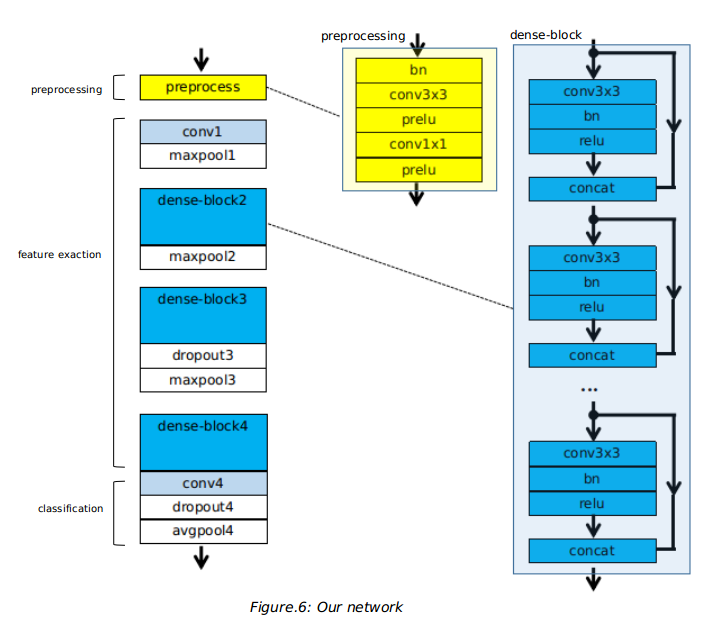

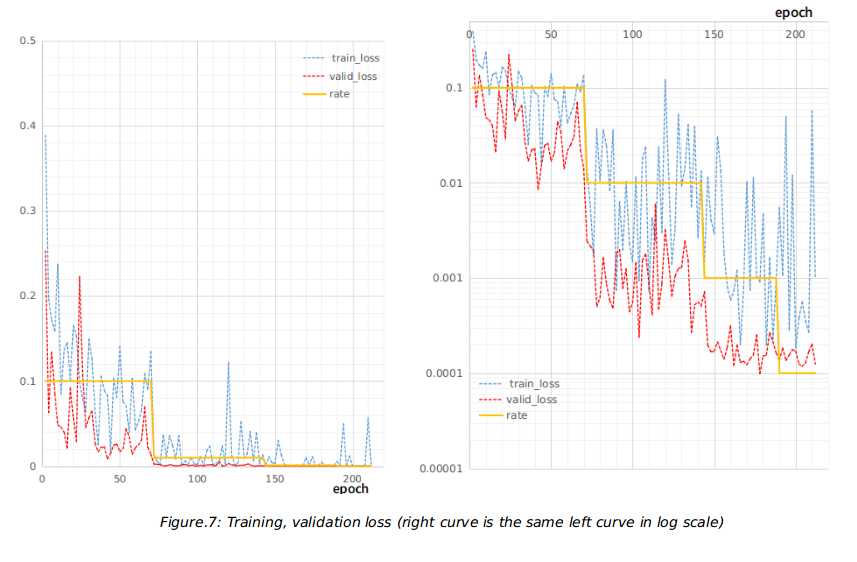

In [16]:
img1=Image(filename="/Users/zoyagerdabad/ART/advance/docs/001.png")
img2=Image(filename="/Users/zoyagerdabad/ART/advance/docs/003.png")
display(img1, img2)

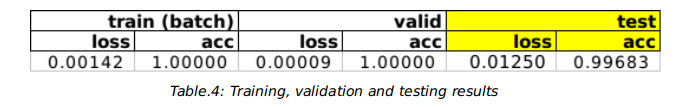

In [17]:
img1=Image(filename="/Users/zoyagerdabad/ART/advance/docs/002.png")
display(img1)

## Step 3: Train the model

Note: if you only want to use saved trained model, do not run this cell. if ran locally, will take a long time to complete.

In [18]:
### Train Model Here

# changing of learning rate
def schdule_by_step( r, steps=(0,100), items=(0.1,0.01)):

    item = items[0]
    N=len(steps)
    for n in range(N):
        if r >= steps[n]:
            item = items[n]
    return item


#for testing and validation
def test_net( datas, labels, batch_size, data, label, loss, metric, sess):

    num = len(datas)
    all_loss = 0
    all_acc = 0
    all = 0
    for n in range(0, num, batch_size):
        #print('\r  evaluating .... %d/%d' % (n, num), end='', flush=True)
        start = n
        end = start+batch_size if start+batch_size<=num else num
        batch_datas  = datas  [start:end]
        batch_labels = labels [start:end]

        fd = {data: batch_datas, label: batch_labels, IS_TRAIN_PHASE : False}
        test_loss, test_acc = sess.run([loss, metric], feed_dict=fd)

        a = end-start
        all += a
        all_loss += a*test_loss
        all_acc  += a*test_acc

    assert(all==num)
    loss = all_loss/all
    acc  = all_acc/all

    return loss, acc


### Following cell block runs the training! 
### If you wish to use trained model, stop here and proceed to "Step 4" where we load the trained model and test it on some sample test data.

In [19]:
#solver 
epoch_log  = 2 
max_run    = 9
batch_size = 128  #256  #96  384  #128
steps = (0, 3, 6, 8)  
rates = (0.1, 0.01,  0.001, 0.0001) 

learning_rate = tf.placeholder(tf.float32, shape=[])
solver = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
solver_step = solver.minimize(loss)



# start training here ------------------------------------------------
print ('start training')
sess.run(tf.global_variables_initializer(), feed_dict = {IS_TRAIN_PHASE : True } )
saver  = tf.train.Saver()
#writer = tf.summary.FileWriter(out_dir + '/tf', graph=tf.get_default_graph())


# keep a log   
print('')
print(' run  epoch   iter    rate      |  train_loss    (acc)     |  valid_loss    (acc)     |  time ')
print('----------------------------------------------------------------------------------------------')

tic = timer()
iter = 0
for r in range(max_run):
    rate = schdule_by_step(r, steps=steps, items=rates)

    argument_images, argument_labels = shuffle_data_uniform(train_images, train_labels, num_class,  num_per_class=num_per_class)
    argument_images = make_perturb_images(argument_images, keep=keep)


    num_argument = len(argument_images)
    N = max(num_argument//batch_size-1,1)
    #iter_log = round(float(num_train) / float(num_argument) * float(N))
    iter_log = max(round(float( epoch_log *num_train ) / float(batch_size)),1)
    for n in range(N):
        iter  = iter + 1
        run   = r + float(n)/float(N)
        epoch = float(iter*batch_size)/float(num_train)

        batch_datas, batch_labels = generate_train_batch_next( argument_images, argument_labels, n, batch_size )

        fd = {data: batch_datas, label: batch_labels, learning_rate: rate, IS_TRAIN_PHASE : True }
        _, batch_loss, batch_acc, = sess.run([solver_step, loss, metric ],feed_dict=fd)

      
        print('\r%4.1f  %5.1f   %05d   %f |  %f    (%f)  ' %
                  (run, epoch, iter, rate, batch_loss, batch_acc), end='', flush=True)

        #do validation here!
        if iter%iter_log==0 or (r==max_run-1 and n==N-1): 
            toc = timer()
            sec_pass = toc - tic
            min_pass = sec_pass/60.

            #validation
            val_loss, val_acc =  test_net(valid_images, valid_labels, batch_size, data, label, loss, metric, sess)

            #print('\r')
            print('\r%4.1f  %5.1f   %05d   %f |  %f    (%f) |  %f    (%f) | %4.1f min' %
                  (run, epoch, iter, rate, batch_loss, batch_acc, val_loss, val_acc, min_pass ), end='\n',flush=True)


        pass

    # save intermediate checkpoint
    # saver.save(sess, out_dir + '/check_points/%06d.ckpt'%r)  #iter


#final test! ------------------------------------------
# save final checkpoint
os.makedirs (OUT_DIR + '/check_points/final.ckpt',exist_ok=True)
saver.save(sess, OUT_DIR + '/check_points/final.ckpt')

print('\n') 
print('** evaluation on test set **' )
test_loss, test_acc = test_net(test_images, test_labels, batch_size, data, label, loss, metric, sess)
print('test_loss=%f    (test_acc=%f)' % ( test_loss, test_acc))

 


start training

 run  epoch   iter    rate      |  train_loss    (acc)     |  valid_loss    (acc)     |  time 
----------------------------------------------------------------------------------------------
 0.1    2.0   00497   0.100000 |  0.549026    (0.867188) |  0.404457    (0.900000) |  8.9 min
 0.1    4.0   00994   0.100000 |  0.161802    (0.953125) |  0.083800    (0.969000) | 14.5 min
 0.2    6.0   01491   0.100000 |  0.250931    (0.937500) |  0.051532    (0.984333) | 20.1 min
 0.3    8.0   01988   0.100000 |  0.095898    (0.976562) |  0.024199    (0.993667) | 25.8 min
 0.4   10.0   02485   0.100000 |  0.072457    (0.976562) |  0.012812    (0.996667) | 31.5 min
 0.4   12.0   02982   0.100000 |  0.088124    (0.968750) |  0.033522    (0.992333) | 37.2 min
 0.5   14.0   03479   0.100000 |  0.036529    (0.976562) |  0.015256    (0.992667) | 42.9 min
 0.6   16.0   03976   0.100000 |  0.112314    (0.968750) |  0.023980    (0.992667) | 48.7 min
 0.7   18.0   04473   0.100000 |  0.090747

---

## Step 4: Test a Model on New Images


In this section we will load some sample pictures that contain traffic signs in them, then will use OpenCV to detect the signs and crop them into 32 x 32 size (which is the input size that our DNN accepts).

Next, we will load our trained model and will feed these cropped images to it and see the results.

num=5


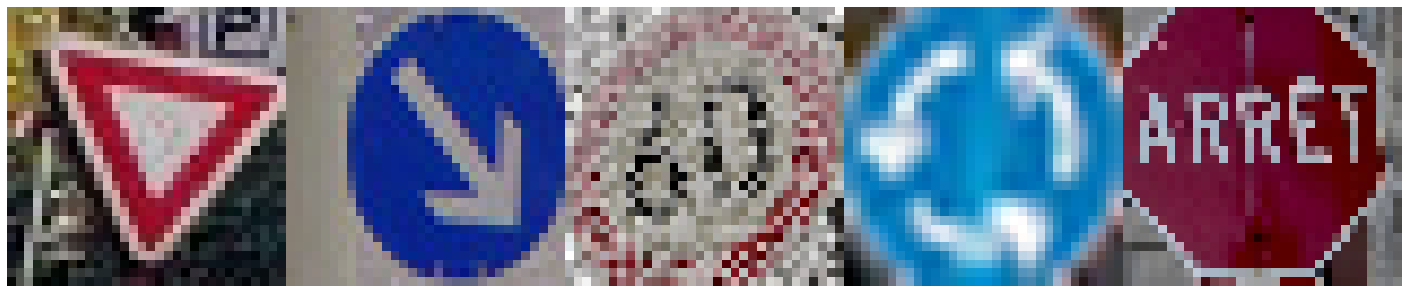

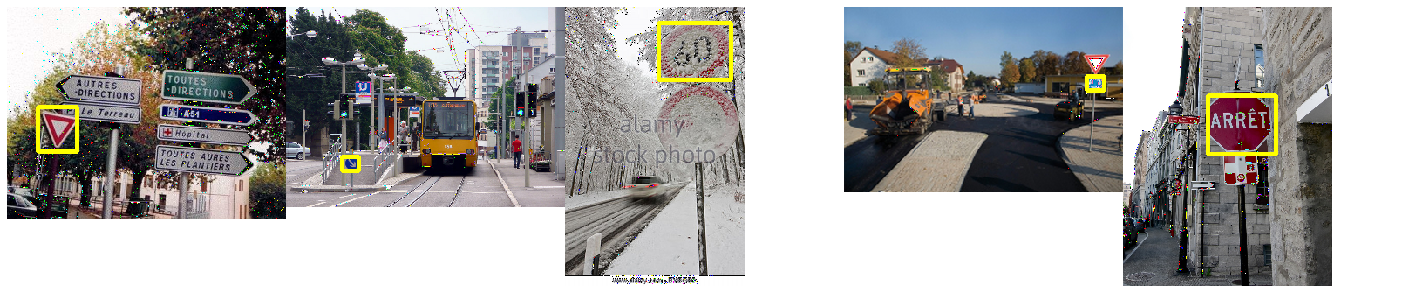

In [20]:
### Load the test images and plot them

test_files=['0004.jpg',   #normal
            '0000.jpg',   #normal
            '0007.jpg',   #occluded with snow
            '0006.jpg',   #small
            '0005.jpg',   #not in class
            ]
test_rois=[(54,180,125,260),(160,430,207,469),(181,32,321,142),(226,65,242,78 ),(388,408,700,676)]
num=len(test_files)
print('num=%d'%num)

# crop roi to 32x32 
results_image  = 255. * np.ones(shape=(1 * height, num* width, channel),dtype=np.float32) 
results_image1 = 255. * np.ones(shape=(1 * 320, num* 320, channel),dtype=np.float32)  
crops = np.zeros(shape=(num,height,width,channel),dtype=np.float32)
for n in range(num):
    img = cv2.imread(DATA_DIR+'/extra/' + test_files[n], 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) 
    x1, y1, x2, y2 = test_rois[n] 
    crop = cv2.resize(img[y1:y2, x1:x2, :], (0, 0), fx=32. / (x2 - x1), fy=32. / (y2 - y1),
                      interpolation=cv2.INTER_CUBIC)
    
    crop = np.clip(crop,0,255)
    crops[n]=crop
    insert_subimage(results_image, crop, 0, n*width)

    
    #mak roi and show
    H,W,C=img.shape
    S=max(H,W)
    f=320./S
    norm_img = cv2.resize(img, (0, 0), fx=f, fy=f, interpolation=cv2.INTER_CUBIC)  
    cv2.rectangle(norm_img, (round(f*x1), round(f*y1)), (round(f*x2), round(f*y2)), (255,255,0), 3)
    insert_subimage(results_image1, norm_img, 0, n*320)     
    

cv2.imwrite(DATA_DIR+'/extra/'+'crops.jpg', cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB) )
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()

plt.imshow(results_image1.astype(np.uint8))
plt.axis('off') 
plt.show()


downloaded 5 images from the internet and determine the roi region of the traffic sign by hand. The images are:

| images        | charateristic       | difficulties                                                        |
| ------------- |:-------------------:| --------------------------------------------------------------------|
| 0004.jpg      | normal              | easy to the classifier                                              |
| 0000.jpg      | normal              | easy to the classifier                                              |
| 0007.jpg      | occluded with snow  | difficult to the classifier, but human can get it correct           |
| 0006.jpg      | small               | easy to the classifier? though human may find it difficult          |
| 0005.jpg      | not in class        | this is not in the training class at all!                           |


In [21]:
### Runing the predictions here

#remember to preprocess!
new_images = crops #preprocess(crops)

# load trained classifier
saver  = tf.train.Saver()
saver.restore(sess, OUT_DIR + '/check_points/final.ckpt')

print('** test on extra **')
fd = {data: new_images, IS_TRAIN_PHASE: False}
test_prob = sess.run(prob, feed_dict=fd)

print('see printout of results in the next jupyter cell!')       
print('sucess')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/zoyagerdabad/ART/model//check_points/final.ckpt
** test on extra **
see printout of results in the next jupyter cell!
sucess


accuracy is 60%. The results are:

| images        | charateristic       | results                             |
| ------------- |:-------------------:| ------------------------------------|
| 0004.jpg      | normal              | correct                             |
| 0000.jpg      | normal              | correct                             |
| 0007.jpg      | occluded with snow  | wrong                               |
| 0006.jpg      | small               | correct                             |
| 0005.jpg      | not in class        | n.a., but results are reasonable    |


In the following cell, you will see the list and visualization of Top-5 predictions for each of the test images.

n=0:
	top0: 0.999975  13:Yield
	top1: 0.000005  04:Speed limit (70km/h)
	top2: 0.000005  34:Turn left ahead
	top3: 0.000004  14:Stop
	top4: 0.000004  24:Road narrows on the right
n=1:
	top0: 0.999982  38:Keep right
	top1: 0.000004  20:Dangerous curve to the right
	top2: 0.000003  05:Speed limit (80km/h)
	top3: 0.000001  34:Turn left ahead
	top4: 0.000001  36:Go straight or right
n=2:
	top0: 0.934988  40:Roundabout mandatory
	top1: 0.018899  28:Children crossing
	top2: 0.007916  37:Go straight or left
	top3: 0.005704  21:Double curve
	top4: 0.003730  18:General caution
n=3:
	top0: 0.999974  40:Roundabout mandatory
	top1: 0.000013  34:Turn left ahead
	top2: 0.000002  05:Speed limit (80km/h)
	top3: 0.000001  33:Turn right ahead
	top4: 0.000001  20:Dangerous curve to the right
n=4:
	top0: 0.999978  14:Stop
	top1: 0.000008  12:Priority road
	top2: 0.000002  33:Turn right ahead
	top3: 0.000001  35:Ahead only
	top4: 0.000001  01:Speed limit (30km/h)


**visual results**:  input, followed by t

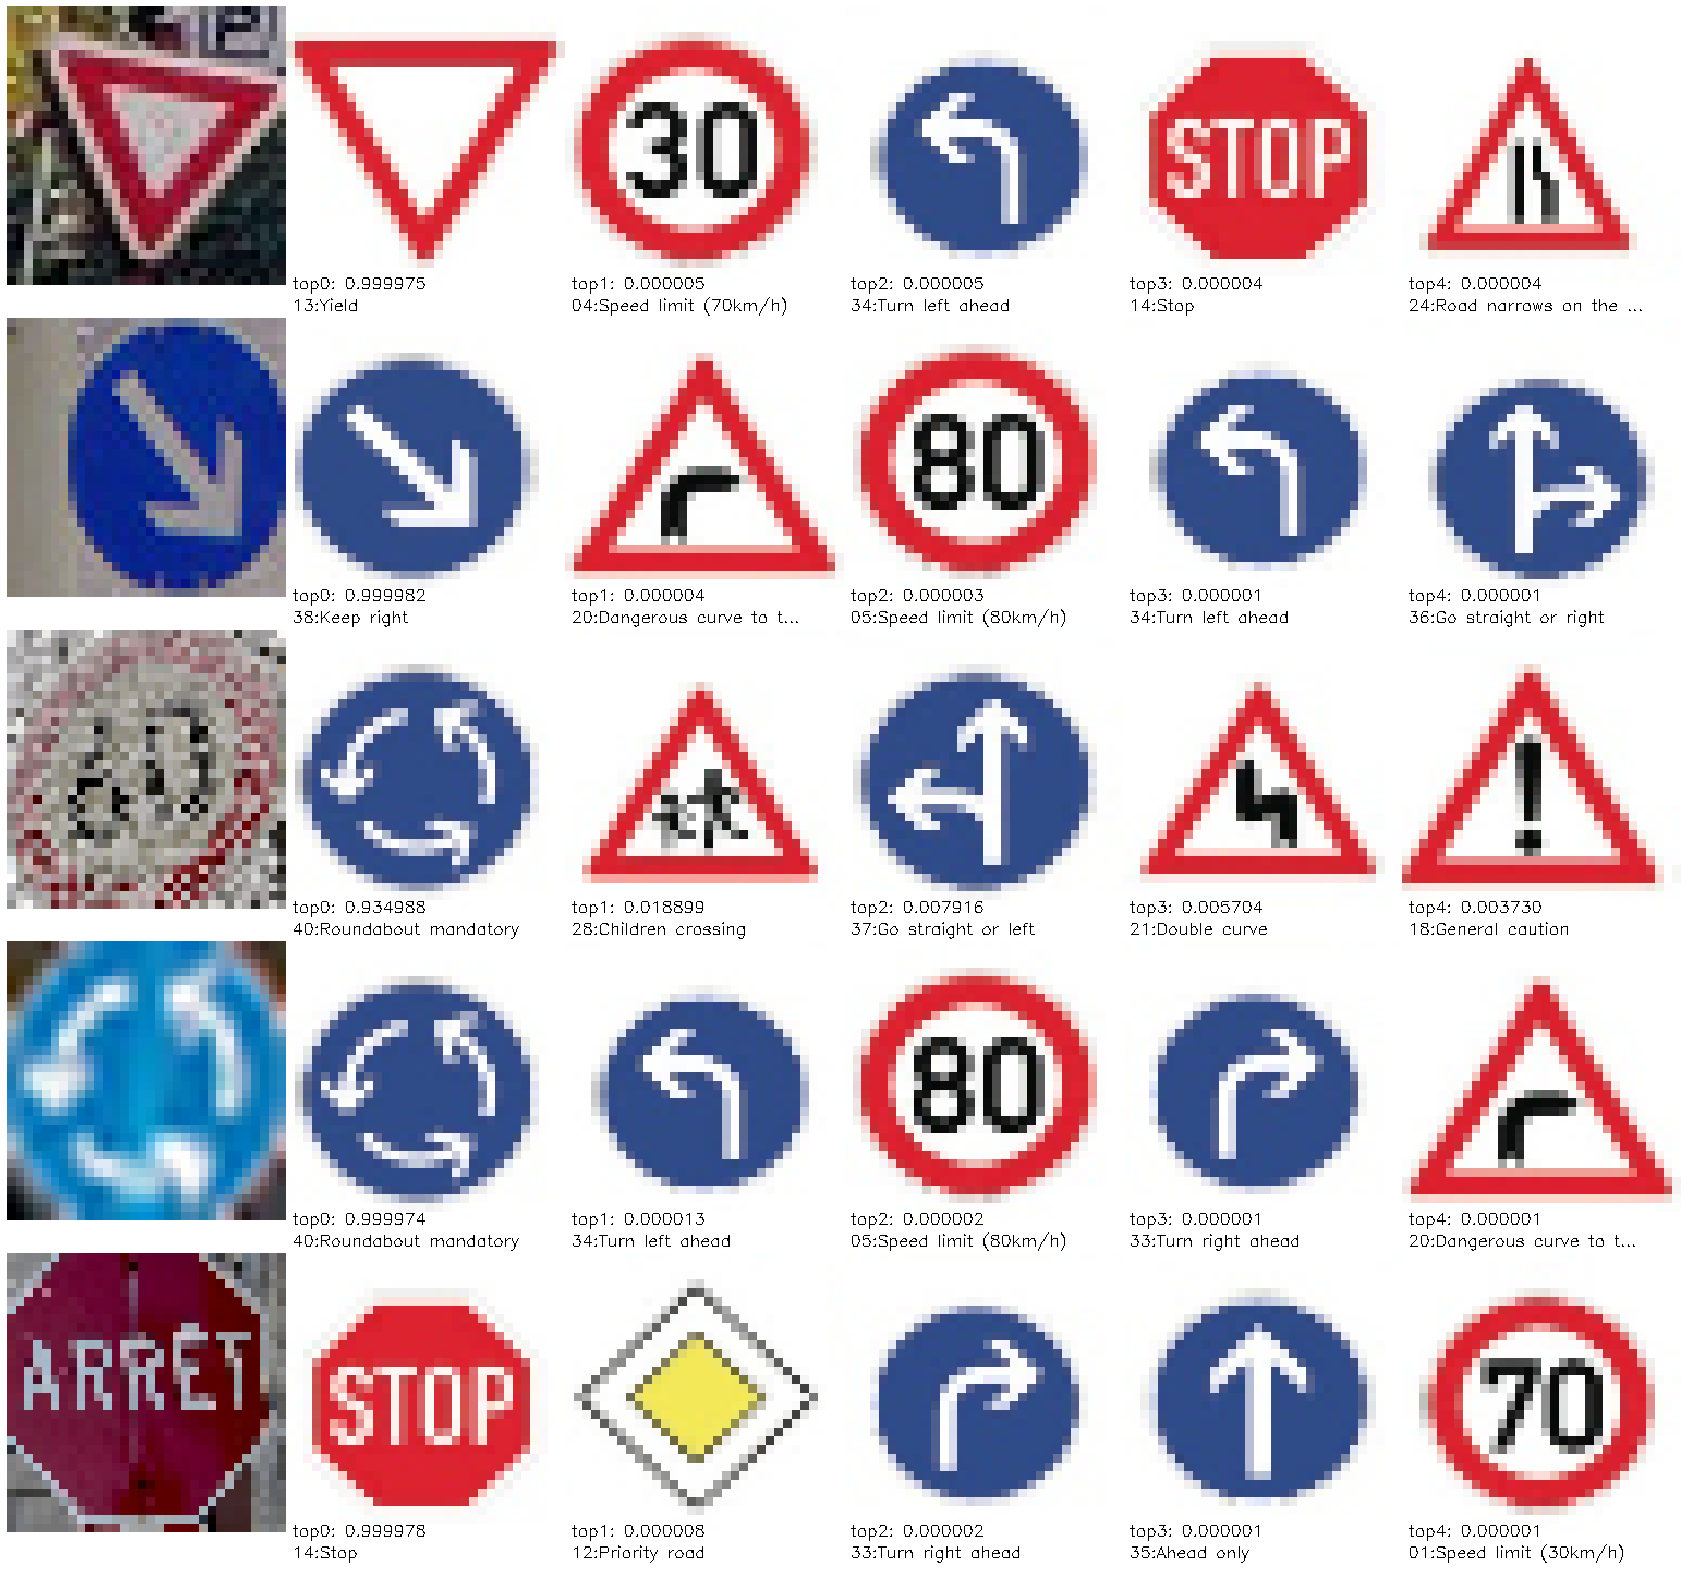

In [23]:
### Visualizing the softmax probabilities here


#show results 
f=8
results_image = 255. * np.ones(shape=(5*(f*height + 30), 6*f*width, channel), dtype=np.float32)

for n in range(num):
    print('n=%d:' % n)
    crop = crops[n]
    #crop = cv2.resize(crop, (0, 0), fx=f, fy=f, interpolation=cv2.INTER_NN)
    crop = crop.repeat(f, axis=0).repeat(f, axis=1)
    insert_subimage(results_image, crop, n * (f*height + 30), 0)

    p = test_prob[n]
    idx = np.argsort(p)[::-1]
    for k in range(5):
        c = int(idx[k])
        label_image = get_label_image(c)
        #label_image = cv2.resize(label_image, (0, 0), fx=f, fy=f, interpolation=cv2.INTER_NN)
        label_image = label_image.repeat(f, axis=0).repeat(f, axis=1)
        insert_subimage(results_image, label_image, n * (f*height + 30), (k + 1) * f*width)


        print('\ttop%d: %f  %02d:%s' % (k, p[c], c, classnames[c]))
        cv2.putText(results_image, 'top%d: %f' % (k, p[c]), (5+(k + 1) * f*width, (n+1) * (f*height + 30)-27), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        cv2.putText(results_image, '%02d:%s%s' % (c, classnames[c][0:20], '...' if len(classnames[c])>20 else ''), (5+(k + 1) * f*width, (n+1) * (f*height + 30)-7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)


    
print('')
print('')    
print('**visual results**:  input, followed by top-5')
cv2.imwrite(OUT_DIR+'/extra_predictions.jpg', cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB) )
plt.rcParams["figure.figsize"] = (30,30)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()

---

## Step 5: Using ART to Attack & Defense

In this section you will load the trained model and start working with ART. 

- You will first define a TFClassifier which is an ART object that will be used as the model when you are working with ART.
- After defining the TFClassifier, you will try it on a clean (non-adversarial) image and see the prediction. 
- Then you will craft an Adversarial image using "Projected Gradient Descent method" and feed it to the model to see its prediction.
- Finally, you will use a defense method called "Feature Squeezing Defence" on the adversarial image to neutralize. Then we will feed it to the model and see the result.

### 5.1. Defining model parameters and loading the trained model

In [9]:
adv_make_net = DenseNet_3

adv_logit  = adv_make_net(input_shape =(32, 32, 3), output_shape=(num_class))
adv_data   = tf.get_default_graph().get_tensor_by_name('input:0')
adv_label  = tf.placeholder(dtype=tf.int32, shape=[None, 43])
adv_prob   = tf.nn.softmax(adv_logit)

adv_l2     = l2_regulariser(decay=0.0005)
adv_loss   = cross_entropy(adv_logit, adv_label)
adv_metric = accuracy(adv_prob, adv_label)

adv_learning_rate = tf.placeholder(tf.float32, shape=[])
adv_solver = tf.train.MomentumOptimizer(learning_rate=adv_learning_rate, momentum=0.9)
adv_solver_step = adv_solver.minimize(adv_loss)

adv_sess = tf.Session()

adv_saver  = tf.train.Saver()
adv_saver.restore(adv_sess, OUT_DIR + '/check_points/final.ckpt')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/zoyagerdabad/ART/model//check_points/final.ckpt


### 5.2. Defining TFClassifier

In [10]:
classifier = TFClassifier(adv_data, adv_logit, output_ph=adv_label, train=adv_solver_step, loss=adv_loss, learning = IS_TRAIN_PHASE, sess=adv_sess, preprocessing= (0, 1))
classifier.set_learning_phase(train=False)

### 5.3. Loading a "Clean" test image and test the TFClassifier on it

You can see that it detected that by 100% confidence it is a stop sign.

Prediction: Stop - confidence 1.00


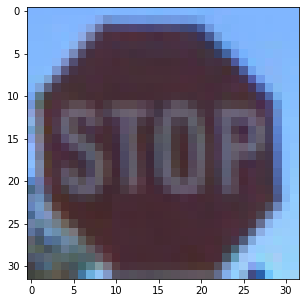

In [11]:
from keras.preprocessing import image

init_img = np.zeros(shape=(1,32,32,3),dtype=np.float32)

image_file = join(DATA_DIR,'extra/stop_001.png')
image_ = image.load_img(image_file, target_size=(32, 32))
init_img = image.img_to_array(image_)
img = init_img[None , ...]

pred = classifier.predict(img)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]
print('Prediction:', classnames[label], '- confidence {0:.2f}'.format(confidence))
plt.figure(figsize=(5,5))
plt.imshow(init_img / 255)

### 5.4. Perform Attack

Here we will use "Projected Gradient Descent" attack. The PGD attack is a white-box attack which means the attacker has access to the model gradients i.e. the attacker has a copy of your model’s weights. This threat model gives the attacker much more power than black box attacks as they can specifically craft their attack to fool your model without having to rely on transfer attacks that often result in human-visible perturbations. PGD can be considered the most “complete” white-box adversary as it lifts any constraints on the amount of time and effort the attacker can put into finding the best attack.

Link to paper: https://arxiv.org/abs/1706.06083

you will perform following steps in this section:

1- Generate an adversarial image using "Projected Gradient Descent"
   - First we generate a noise
   - Then apply it to the original image to craft the adversarial image
   
2- Feed the Adversary to the classifier and evaluate it on the trained model

3- Finally we visualize the images (original, the crafted noise, adversarial image and a representation of the class that was predicted based on the adversarial image)

Prediction: Ahead only - confidence 0.92


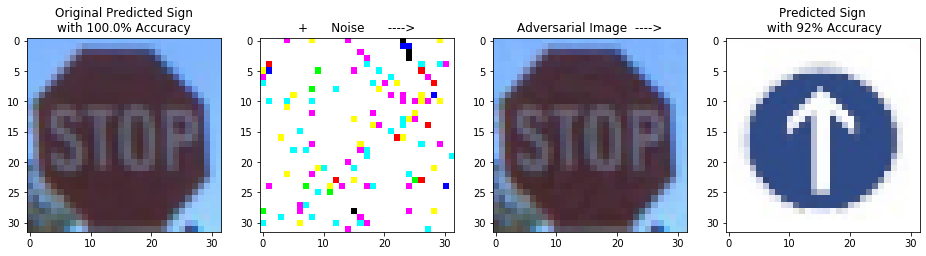

In [12]:
adv = ProjectedGradientDescent(classifier, targeted=False, eps_step=1, eps=2, max_iter=20)

# Generate attack image
img_adv = adv.generate(img)

# Evaluate it on model
pred_adv = classifier.predict(img_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', classnames[label_adv], '- confidence {0:.2f}'.format(confidence_adv) ) 

fig = plt.figure(figsize=(16,16))

a = fig.add_subplot(1, 4, 1)
a.set_title('Original Predicted Sign\nwith {0:.1f}% Accuracy'.format(100*confidence), fontsize=12)
imgplot = plt.imshow(img[0] / 255)
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 2)
a.set_title('+      Noise      ---->', fontsize=12)
imgplot = plt.imshow(np.abs(img[0] - img_adv[0]) )

a = fig.add_subplot(1, 4, 3)
a.set_title('Adversarial Image  ---->', fontsize=12)
imgplot = plt.imshow(img_adv[0] / 255)

a = fig.add_subplot(1, 4, 4)
a.set_title('Predicted Sign\n with {0:.0f}% Accuracy'.format(100*confidence_adv), fontsize=12)
im = get_label_image(int(label_adv))
imL = cv2.resize(im, dsize=(32, 32), interpolation=cv2.INTER_LINEAR)
imgL = np.float32(imL)
imgplot = plt.imshow(imgL / 255)

#### Take a closer look at the noise
Below is the visualization of the crafted noise that was added to the original image
We can measure the quantity of noise that was introduced to the image by the attack under different $L_p$ norms. Notive that the projected gradient descent attacks optimizes the $L_0$ norm.

Noise L_0 norm: 2%
Noise L_2 norm: 2%
Noise L_inf norm: 1%


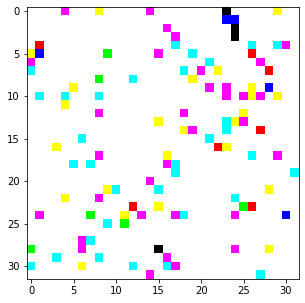

In [13]:
import numpy as np

l0 = int(99*len(np.where(np.abs(img[0] - img_adv[0])>0.5)[0]) / (224*224*3)) + 1   
l1 = int(99*np.sum(np.abs(img[0] - img_adv[0])) / np.sum(np.abs(img[0]))) + 1
l2 = int(99*np.linalg.norm(img[0] - img_adv[0]) / np.linalg.norm(img[0])) + 1 
linf = int(99*np.max(np.abs(img[0] - img_adv[0])) / 255) + 1
print('Noise L_0 norm: %d%%' % l0)
print('Noise L_2 norm: %d%%' % l2)
print('Noise L_inf norm: %d%%' % linf)
plt.figure(figsize=(5,5))
plt.imshow(np.abs(img[0] - img_adv[0]))

### 5.5. Apply Defense

Here we use "Feature Squeezing" defense to neutralize the adversarial image. We assume that we already know the image is manipulated and now we want to neutralize the image in a way that it can be cotrrectly classified.

Feature squeezing reduces the search space available to an adversary by coalescing samples that correspond to many different feature vectors in the original space into a single sample. By comparing a DNN model’s prediction on the original input with that on squeezed inputs, feature squeezing detects adversarial examples with high accuracy.

This method is based on paper named "Feature Squeezing: Detecting Adversarial Examples in Deep Neural Networks" by Weilin Xu, David Evans, Yanjun Qi from University of Virginia. Link : https://arxiv.org/abs/1704.01155

Prediction: Stop - confidence 0.97


Text(0.5, 1.0, 'Cleaned Image\n Correctly classified with 97% Accuracy')

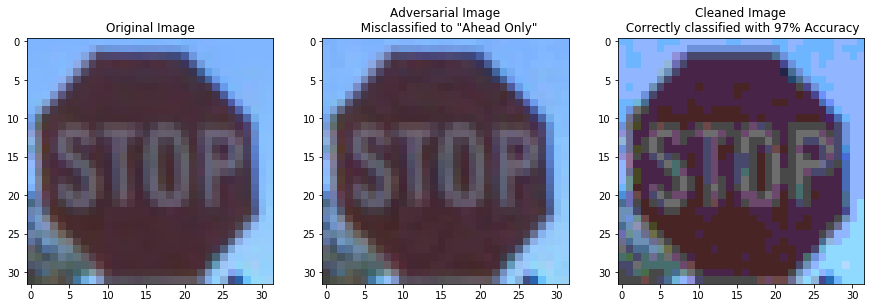

In [20]:
from art.defences import FeatureSqueezing

fs = FeatureSqueezing(bit_depth=3, clip_values=(0, 255))
img_def = fs(img_adv)
pred_def = classifier.predict(img_def[0])
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]
print('Prediction:', classnames[label_def], '- confidence {0:.2f}'.format(confidence_def))

fig = plt.figure(figsize=(15,15))

a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(img[0] / 255)
imgplot.set_clim(0.0, 0.7)
a.set_title('Original Image')

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(img_adv[0] / 255)
a.set_title('Adversarial Image\n  Misclassified to "Ahead Only"', fontsize=12)

a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(img_def[0][0] / 255)
imgplot.set_clim(0.0, 0.7)
a.set_title('Cleaned Image\n Correctly classified with {0:.0f}% Accuracy'.format(100*confidence_def), fontsize=12)

### Refrences

[1]  The Traffic sign classifier uses German Traffic Sign dataset: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

[2]  The code to define and train the model was used from the code in https://github.com/hengck23-udacity/udacity-driverless-car-nd-p2

[3]  "Densely Connected Convolutional Networks" - Gao Huang, Zhuang Liu, Kilian Q. Weinberger, Laurens van der Maaten, Arxiv 2016